<a href="https://colab.research.google.com/github/akash1629/AI-Powered-Anomaly-Detection-in-Time-Series-Data/blob/main/AI_POWERED_ANOMALY_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow numpy pandas matplotlib scikit-learn --quiet


<ipython-input-1-5100f019e6f7>:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["timestamp"] = pd.date_range(start="2023-01-01", periods=time_steps, freq="H")  # example hourly data


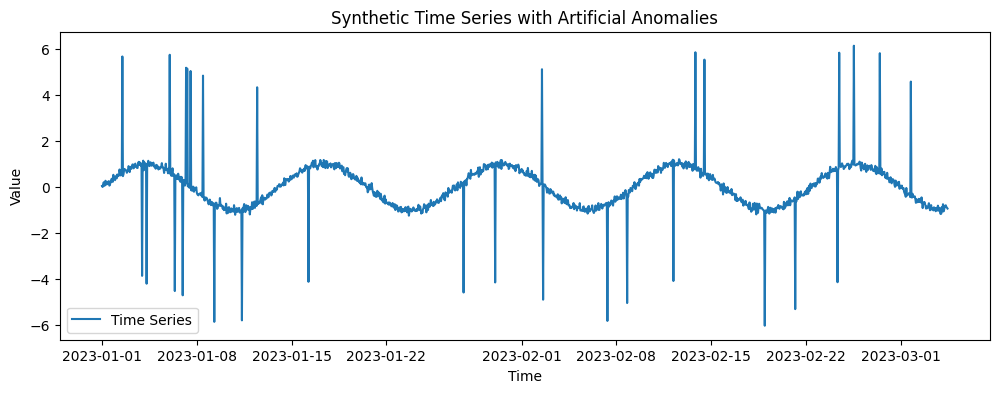

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set a seed for reproducibility
np.random.seed(42)

# 2.1 Generate a Sine Wave
time_steps = 1500
t = np.arange(0, time_steps)
sine_wave = np.sin(0.02 * t)  # Sine wave with a specific frequency

# 2.2 Add Random Noise
noise = np.random.normal(0, 0.1, size=time_steps)
data = sine_wave + noise

# 2.3 Inject Artificial Anomalies
# We'll randomly pick ~2% of points to be "anomalies" by adding a large spike or dip.
anomaly_indices = np.random.choice(time_steps, size=int(0.02 * time_steps), replace=False)
data[anomaly_indices] += np.random.choice([-5, 5], size=len(anomaly_indices))

# 2.4 Convert to a DataFrame (optional but convenient)
df = pd.DataFrame({"value": data})
df["timestamp"] = pd.date_range(start="2023-01-01", periods=time_steps, freq="H")  # example hourly data
df = df[["timestamp", "value"]]

# Plot the generated data
plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["value"], label="Time Series")
plt.title("Synthetic Time Series with Artificial Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# 3.1 Hyperparameters
sequence_length = 30  # Each sequence of data will be 30 steps long
train_size_ratio = 0.7  # 70% of data for training, 30% for testing

# 3.2 Min-Max Scale the data for easier NN training
scaler = MinMaxScaler()
df["scaled_value"] = scaler.fit_transform(df[["value"]])

# 3.3 Function to create sequences
def create_sequences(data_array, seq_len=30):
    sequences = []
    for i in range(len(data_array) - seq_len):
        seq = data_array[i : i + seq_len]
        sequences.append(seq)
    return np.array(sequences)

# 3.4 Split into train/test
train_size = int(len(df) * train_size_ratio)
train_data = df["scaled_value"].values[:train_size]
test_data  = df["scaled_value"].values[train_size:]

# Create sequences for training and testing
X_train = create_sequences(train_data, sequence_length)
X_test = create_sequences(test_data, sequence_length)

# Reshape for LSTM: (samples, timesteps, features=1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Train sequences shape:", X_train.shape)
print("Test sequences shape:", X_test.shape)


Train sequences shape: (1020, 30, 1)
Test sequences shape: (420, 30, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# 4.1 Define the Model Architecture
def build_lstm_autoencoder(seq_len=30, n_features=1, latent_dim=16):
    # Encoder
    inputs = Input(shape=(seq_len, n_features))
    encoded = LSTM(latent_dim, activation="relu")(inputs)

    # Latent Representation
    latent = RepeatVector(seq_len)(encoded)

    # Decoder
    decoded = LSTM(latent_dim, activation="relu", return_sequences=True)(latent)
    decoded = TimeDistributed(Dense(n_features))(decoded)

    # Construct the Autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder

# 4.2 Instantiate and Summarize
model = build_lstm_autoencoder(seq_len=sequence_length, n_features=1, latent_dim=16)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.2250 - val_loss: 0.1096
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0576 - val_loss: 0.0201
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0203 - val_loss: 0.0167
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0167 - val_loss: 0.0136
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0136 - val_loss: 0.0103
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

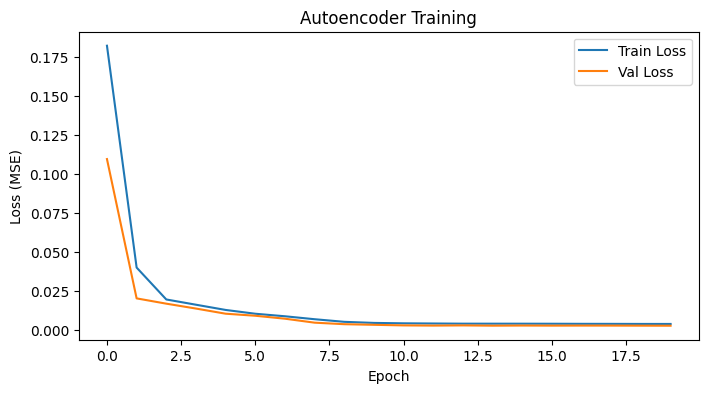

In [ ]:
# 5.1 Training
epochs = 20
batch_size = 32

history = model.fit(
    X_train, X_train,  # Autoencoder attempts to reconstruct the same input
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    shuffle=True
)

# 5.2 Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder Training")
plt.legend()
plt.show()


In [ ]:
# 6.1 Calculate reconstruction error
reconstructions = model.predict(X_train)
train_mse = np.mean(np.power(X_train - reconstructions, 2), axis=(1,2))

# 6.2 Decide threshold
threshold = np.mean(train_mse) + 3 * np.std(train_mse)
print("Reconstruction error threshold:", threshold)

# 6.3 Check test reconstruction error
test_reconstructions = model.predict(X_test)
test_mse = np.mean(np.power(X_test - test_reconstructions, 2), axis=(1,2))

# 6.4 Label test sequences as anomalies or normal
anomaly_labels = (test_mse > threshold).astype(int)  # 1 = anomaly, 0 = normal
print("Number of anomalies in test set:", np.sum(anomaly_labels))


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Reconstruction error threshold: 0.017794583623787472
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Number of anomalies in test set: 1


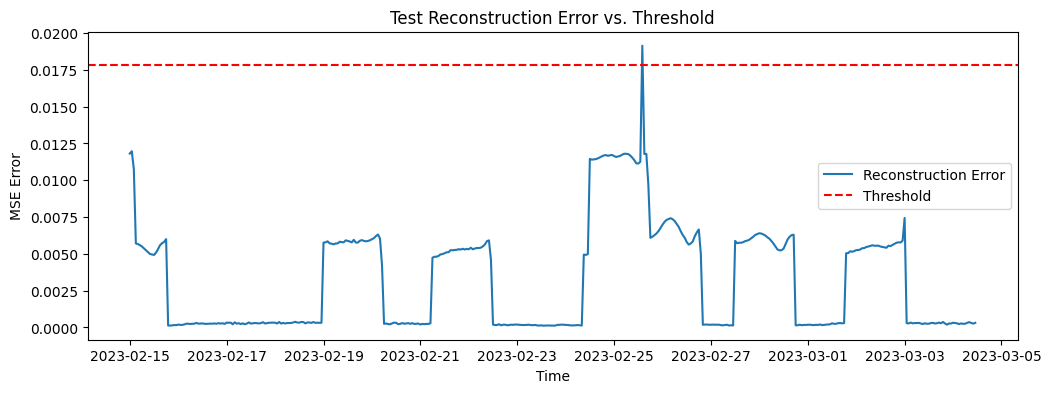

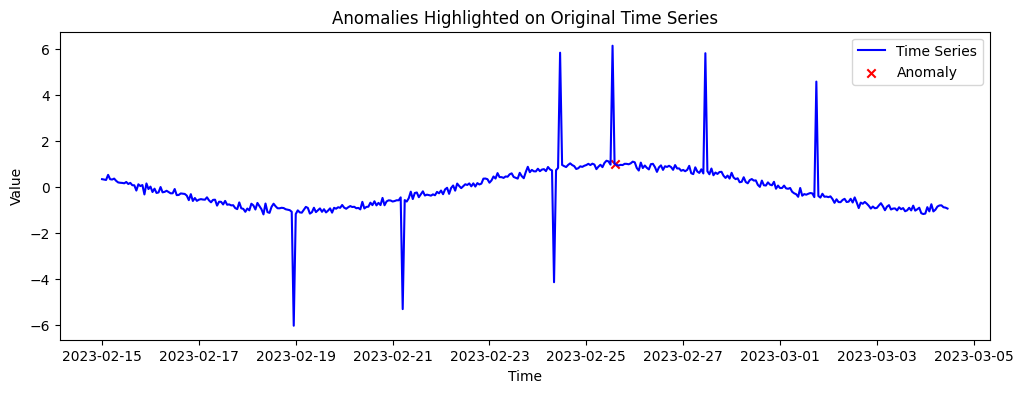

In [ ]:
# 7.1 Align anomaly labels with time
test_time_index = df["timestamp"].values[train_size + sequence_length:]
df_test = pd.DataFrame({
    "timestamp": test_time_index,
    "reconstruction_error": test_mse,
    "anomaly_label": anomaly_labels
})

plt.figure(figsize=(12,4))
plt.plot(df_test["timestamp"], df_test["reconstruction_error"], label="Reconstruction Error")
plt.axhline(y=threshold, color="r", linestyle="--", label="Threshold")
plt.title("Test Reconstruction Error vs. Threshold")
plt.xlabel("Time")
plt.ylabel("MSE Error")
plt.legend()
plt.show()

# 7.2 Highlight anomalies on the raw values
df_test = df_test.merge(df, on="timestamp", how="left")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_test["timestamp"], df_test["value"], label="Time Series", color="blue")
anomalies = df_test[df_test["anomaly_label"] == 1]
ax.scatter(anomalies["timestamp"], anomalies["value"], color="red", label="Anomaly", marker="x")
plt.title("Anomalies Highlighted on Original Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# Suppose you have an array 'true_labels' of the same length as test_reconstructions
# 1 = anomaly, 0 = normal
from sklearn.metrics import classification_report

# Example: If we artificially create a ground-truth for demonstration
# (In a real scenario, read from your domain-labeled data)
true_labels = np.zeros_like(anomaly_labels)
# Let's mark the known synthetic anomalies in the test portion
# (this is simplistic, as in real data you would have them labeled)
# For demonstration, we skip implementing exactly the matching logic.

# Evaluate
report = classification_report(true_labels, anomaly_labels, labels=[0,1], target_names=["Normal","Anomaly"])
print(report)


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       420
     Anomaly       0.00      0.00      0.00         0

    accuracy                           1.00       420
   macro avg       0.50      0.50      0.50       420
weighted avg       1.00      1.00      1.00       420



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install -q streamlit pyngrok nest_asyncio tensorflow numpy pandas matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()  # Allow nested event loops in Colab

from pyngrok import ngrok


In [ ]:
%%writefile anomaly_app.py
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# --------------------------------------------------
# Helper Functions
# --------------------------------------------------

def create_synthetic_data(n_points=1500, anomaly_fraction=0.02, noise_level=0.1):
    """
    Creates synthetic time series data (sine wave + noise)
    with injected anomalies (spikes).
    """
    np.random.seed(42)
    t = np.arange(n_points)
    # Base sine wave
    sine_wave = np.sin(0.02 * t)
    # Add noise
    noise = np.random.normal(0, noise_level, size=n_points)
    data = sine_wave + noise
    # Inject anomalies
    anomaly_indices = np.random.choice(n_points,
                                       size=int(anomaly_fraction * n_points),
                                       replace=False)
    data[anomaly_indices] += np.random.choice([-5, 5], size=len(anomaly_indices))
    return data

def create_sequences(data_array, seq_len=30):
    """
    Converts 1D array into 3D array of shape (samples, seq_len, 1)
    for LSTM input.
    """
    sequences = []
    for i in range(len(data_array) - seq_len):
        seq = data_array[i : i + seq_len]
        sequences.append(seq)
    return np.array(sequences)

def build_lstm_autoencoder(seq_len=30, n_features=1, latent_dim=16):
    """
    Builds a simple LSTM autoencoder:
     - Encoder: LSTM -> latent
     - Decoder: LSTM -> output sequence
    """
    inputs = Input(shape=(seq_len, n_features))

    # Encoder
    encoded = LSTM(latent_dim, activation="relu")(inputs)
    latent = RepeatVector(seq_len)(encoded)

    # Decoder
    decoded = LSTM(latent_dim, activation="relu", return_sequences=True)(latent)
    decoded = TimeDistributed(Dense(n_features))(decoded)

    # Compile
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(), loss="mse")
    return autoencoder


# --------------------------------------------------
# Streamlit Dashboard
# --------------------------------------------------

def main():
    st.title("LSTM Autoencoder - Time Series Anomaly Detection")

    st.markdown("""
    This dashboard demonstrates how to detect anomalies in a synthetic time series
    using an LSTM autoencoder. Adjust the parameters below to see how they affect
    training time and anomaly detection results.
    """)

    # Sidebar controls
    st.sidebar.header("Model & Data Parameters")
    n_points = st.sidebar.slider("Total Data Points", min_value=500, max_value=3000, value=1500, step=100)
    anomaly_fraction = st.sidebar.slider("Anomaly Fraction", 0.0, 0.1, 0.02, 0.01)
    noise_level = st.sidebar.slider("Noise Level", 0.0, 0.5, 0.1, 0.01)
    seq_len = st.sidebar.slider("Sequence Length", min_value=10, max_value=60, value=30, step=5)
    latent_dim = st.sidebar.slider("Latent Dimension", min_value=4, max_value=64, value=16, step=4)
    epochs = st.sidebar.slider("Training Epochs", min_value=5, max_value=50, value=20, step=5)

    # Generate data button
    if st.button("Generate & Train"):
        # Generate synthetic data
        data = create_synthetic_data(n_points, anomaly_fraction, noise_level)
        df = pd.DataFrame({"value": data})
        df["timestamp"] = pd.date_range("2023-01-01", periods=n_points, freq="H")
        df = df[["timestamp", "value"]]

        # Plot raw data
        st.subheader("Synthetic Time Series (raw)")
        fig_raw, ax_raw = plt.subplots(figsize=(10,3))
        ax_raw.plot(df["timestamp"], df["value"], label="Value")
        ax_raw.set_title("Time Series with Potential Anomalies")
        ax_raw.set_xlabel("Time")
        ax_raw.set_ylabel("Value")
        ax_raw.legend()
        st.pyplot(fig_raw)

        # Scale data
        scaler = MinMaxScaler()
        df["scaled_value"] = scaler.fit_transform(df[["value"]])

        # Split train/test
        train_size = int(len(df) * 0.7)
        train_data = df["scaled_value"].values[:train_size]
        test_data  = df["scaled_value"].values[train_size:]

        # Create windowed sequences
        X_train = create_sequences(train_data, seq_len=seq_len)
        X_test  = create_sequences(test_data, seq_len=seq_len)

        # Reshape for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Build and train autoencoder
        autoencoder = build_lstm_autoencoder(seq_len=seq_len, n_features=1, latent_dim=latent_dim)
        history = autoencoder.fit(X_train, X_train,
                                  epochs=epochs,
                                  batch_size=32,
                                  validation_split=0.1,
                                  shuffle=True,
                                  verbose=0)

        # Plot training history
        st.subheader("Training Loss")
        fig_loss, ax_loss = plt.subplots(figsize=(6,3))
        ax_loss.plot(history.history["loss"], label="Train Loss")
        ax_loss.plot(history.history["val_loss"], label="Val Loss")
        ax_loss.set_title("Autoencoder Training Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("MSE")
        ax_loss.legend()
        st.pyplot(fig_loss)

        # Reconstruction errors (train)
        train_preds = autoencoder.predict(X_train)
        train_mse = np.mean(np.power(X_train - train_preds, 2), axis=(1,2))

        # Choose threshold: mean + 3*std (simple heuristic)
        threshold = np.mean(train_mse) + 3*np.std(train_mse)

        # Test reconstruction error & label
        test_preds = autoencoder.predict(X_test)
        test_mse = np.mean(np.power(X_test - test_preds, 2), axis=(1,2))
        anomaly_labels = (test_mse > threshold).astype(int)

        # Align labels with timestamps
        test_time_index = df["timestamp"].values[train_size + seq_len:]
        df_test = pd.DataFrame({
            "timestamp": test_time_index,
            "recon_error": test_mse,
            "anomaly": anomaly_labels
        })
        df_test = df_test.merge(df, on="timestamp", how="left")

        # Plot reconstruction error
        st.subheader("Reconstruction Error (Test)")
        fig_error, ax_error = plt.subplots(figsize=(10,3))
        ax_error.plot(df_test["timestamp"], df_test["recon_error"], label="Recon Error")
        ax_error.axhline(threshold, color="r", linestyle="--", label=f"Threshold={threshold:.4f}")
        ax_error.set_title("Test Reconstruction Error vs Threshold")
        ax_error.set_xlabel("Time")
        ax_error.set_ylabel("MSE Error")
        ax_error.legend()
        st.pyplot(fig_error)

        # Plot anomalies on time series
        st.subheader("Detected Anomalies on Time Series")
        fig_anom, ax_anom = plt.subplots(figsize=(10,3))
        ax_anom.plot(df_test["timestamp"], df_test["value"], label="Value", color="blue")
        anomalies = df_test[df_test["anomaly"] == 1]
        ax_anom.scatter(anomalies["timestamp"], anomalies["value"], color="red", marker="x", label="Anomaly")
        ax_anom.set_xlabel("Time")
        ax_anom.set_ylabel("Value")
        ax_anom.set_title("Anomalies Highlighted")
        ax_anom.legend()
        st.pyplot(fig_anom)

        st.write("**Anomaly Summary**")
        n_anomalies = anomalies.shape[0]
        st.write(f"Detected **{n_anomalies}** anomalies in the test set.")

if __name__ == "__main__":
    main()


Writing anomaly_app.py


In [ ]:
# 3.1 (Optional) Set your ngrok authtoken to get stable subdomains
# Replace <YOUR_NGROK_AUTH_TOKEN> with your actual token from https://dashboard.ngrok.com/get-started/your-authtoken
!ngrok config add-authtoken "2pyOuyYRgyTnErRsTWG2TdtqSgt_3icDsa8VsL86vVnAm9Xcu"

# 3.2 Start the ngrok tunnel on port 8501
public_url = ngrok.connect(addr="8501")
print("Streamlit App URL:", public_url.public_url)

# 3.3 Launch Streamlit
!streamlit run anomaly_app.py --server.port 8501 &

# Just wait a few seconds until the server logs show "Running on ...".
# Then click the public URL above to access your app.


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit App URL: https://f5e4-34-32-142-157.ngrok-free.app



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.32.142.157:8501

2025-01-13 09:33:05.736125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 09:33:05.759866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 09:33:05.768828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 09:33:05.791282: I tensorflow/core/platform/cpu_

  Stopping...
